# Notebook for responding to the Google Form about Alzhiemer's Disease

This notebook is the code to respond to the google form https://docs.google.com/forms/d/e/1FAIpQLSfLWFJnlK_CEyLQCRE6zJuar-JtuS5RgC0knfOJ4dUdXhb_uQ/viewform. We will take the responses from a user and send them an email with their predicted change in MMSE score using the machine learning model developed in "ADCLASSIFICATION.ipynb."

In [145]:
import pandas as pd

In [146]:
df = pd.read_csv("Do you have Alzheimer's Disease (Responses) - Form Responses 1.csv") # Getting the information from the google sheet 

In [147]:
df = df.tail(1) #Getting the latest row

In [148]:
df

,Timestamp,Name,Email,AGE,Biological Gender,Years of Education(Input a number),What is your Ethnicity?,What is your Race?,What is your APOE4\tgenotype,What is your MMSE test score,Enter True if you have imputed genotypes. Otherwise simply enter False,"What is your APOE Genotype (Please enter like the example: EX: '3,3')"
0,3/3/2021 1:16:16,Rohan Penmatcha,rpenmatc@gmail.com,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4"


In [149]:
email = df['Email']
Input = df
Input = df.drop(['Timestamp', 'Name', 'Email'], axis=1) # Remove Unneccesary Data
Input

,AGE,Biological Gender,Years of Education(Input a number),What is your Ethnicity?,What is your Race?,What is your APOE4\tgenotype,What is your MMSE test score,Enter True if you have imputed genotypes. Otherwise simply enter False,"What is your APOE Genotype (Please enter like the example: EX: '3,3')"
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4"


In [150]:
email 

0    rpenmatc@gmail.com
Name: Email, dtype: object

In [151]:
Input = Input.rename(columns={'Biological Gender': 'PTGENDER'})
Input = Input.rename(columns={'Biological Gender': 'PTGENDER'})
Input = Input.rename(columns={'Years of Education(Input a number)': 'PTEDUCAT'})
Input = Input.rename(columns={'What is your Ethnicity? ': 'PTETHCAT'})
Input = Input.rename(columns={'What is your Race?': 'PTRACCAT'})
Input = Input.rename(columns={'What is your APOE4\tgenotype': 'APOE4'})
Input = Input.rename(columns={'What is your MMSE test score': 'MMSE'})
Input = Input.rename(columns={'Enter True if you have imputed genotypes. Otherwise simply enter False': 'imputed_genotype'})
Input = Input.rename(columns={"What is your APOE Genotype (Please enter like the example: EX: '3,3')": 'APOE Genotype'})
Input['Dx Codes for Submission'] = "AD"

In [152]:
Input

,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD


In [153]:
import numpy as np
import sklearn as sk
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math 

from numpy import mean
from numpy import std
from numpy import absolute
from math import sqrt
from numpy.random import randn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold

warnings.filterwarnings('ignore')
%matplotlib inline

In [154]:
data = pd.read_csv("ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv") 

In [155]:
data = data.drop(['directory.id', 'Subject', 'Image.Data.ID', 'RID', 'Modality', 'Visit',  'Acq.Date', 'DX.bl', 'EXAMDATE'], axis=1) # Remove Unneccesary Data
for var in range(0, len(data)):
    if (data.at[var,"Dx Codes for Submission"] == "MCI"):
        data.at[var,"Dx Codes for Submission"] = "NOT AD"
    if (data.at[var,"Dx Codes for Submission"] == "CN"): 
        data.at[var,"Dx Codes for Submission"] = "NOT AD"
data

,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",NOT AD
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",NOT AD
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3",NOT AD
4,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4",AD
...,...,...,...,...,...,...,...,...,...,...
623,74.4,Female,12,Not Hisp/Latino,White,1,29,True,"3,4",NOT AD
624,69.4,Male,19,Not Hisp/Latino,White,1,29,True,"3,4",NOT AD
625,75.6,Female,16,Not Hisp/Latino,White,0,28,True,"3,3",NOT AD
626,83.4,Male,18,Not Hisp/Latino,White,0,26,True,"3,3",NOT AD


In [156]:
data = data.append(Input)
categorical_variables = ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'imputed_genotype', 'APOE Genotype', 'Dx Codes for Submission']
for var in categorical_variables:
    if (var == 'Dx Codes for Submission'):
        X = data.drop(["Dx Codes for Submission"], axis=1)
        y = data["Dx Codes for Submission"]
    data = pd.concat([data, pd.get_dummies(data[var])], axis=1)
    data = data.drop(var, axis=1)
r = len(data)
Input = data.iloc[[r - 1]]
Input #Getting the information for the user after running through One Hot Encoder
data = data[:628]
data

,AGE,PTEDUCAT,APOE4,MMSE,Female,Male,Hisp/Latino,Not Hisp/Latino,Unknown,Asian,...,False,True,"2,2","2,3","2,4","3,3","3,4","4,4",AD,NOT AD
0,81.3,18,1,20,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
1,67.5,10,0,27,0,1,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,73.7,16,0,29,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,80.4,13,0,25,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,73.9,12,1,24,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,74.4,12,1,29,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
624,69.4,19,1,29,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
625,75.6,16,0,28,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
626,83.4,18,0,26,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1


In [157]:
Input = Input.drop(["AD", "NOT AD"], axis = 1)

In [158]:
Input

,AGE,PTEDUCAT,APOE4,MMSE,Female,Male,Hisp/Latino,Not Hisp/Latino,Unknown,Asian,Black,White,False,True,"2,2","2,3","2,4","3,3","3,4","4,4"
0,81.3,18,1,20,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0


In [159]:
data = pd.read_csv("ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv") # Get the Data 
data = data.drop(['directory.id', 'Subject', 'Image.Data.ID', 'RID', 'Modality', 'Visit',  'Acq.Date', 'DX.bl', 'EXAMDATE'], axis=1) # Remove Unneccesary Data
for var in range(0, len(data)):
    if (data.at[var,"Dx Codes for Submission"] == "MCI"):
        data.at[var,"Dx Codes for Submission"] = "NOT AD"
    if (data.at[var,"Dx Codes for Submission"] == "CN"): 
        data.at[var,"Dx Codes for Submission"] = "NOT AD"
categorical_variables = ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'imputed_genotype', 'APOE Genotype', 'Dx Codes for Submission']
for var in categorical_variables:
    if (var == 'Dx Codes for Submission'):
        X = data.drop(["Dx Codes for Submission"], axis=1)
        y = data["Dx Codes for Submission"]
    data = pd.concat([data, pd.get_dummies(data[var])], axis=1)
    data = data.drop(var, axis=1)
r = len(data)

In [160]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
Binary_Y = label_binarize(y, classes=['AD', 'NOT AD'])
X_train, X_test, y_train, y_test = train_test_split(X, Binary_Y , random_state=0)

In [161]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [162]:
y_pred = gnb.fit(X_train, y_train).predict(Input)

In [166]:
if (y_pred[0] == 0): 
    Condition = "You have Alzheimer's Disease. AD is a very severe disease and you should go to the hospital almost immediately for medication and information."
else:
    Condition = "You do not Alzheimer's Disease. Congrats, you don't have Alzheimer's Disease"

In [167]:
pip install secure-smtplib #required installation to send the email 

Note: you may need to restart the kernel to use updated packages.


In [168]:
import smtplib

gmail_user = 'rpenmatc@gmail.com' #My email that I will use to send the information
gmail_password = 'PASSWORD(HIDDEN FOR PRIVACY)'  #PASSWORD(HIDDEN FOR PRIVACY)

sent_from = gmail_user 
to = ['rpenmatc@gmail.com']
subject = "RESPONSE TO IF YOU HAVE Azheimer's Disease. IMPORTANT!!!!"
body = "Hello, thank you for taking your time to fill out this form. \n\n Results: " + Condition + "  \n\n Here is a link for information to understand more about Alzhiemer's Disease: https://www.alz.org/alzheimers-dementia/what-is-alzheimers. \n\n Thank You, \n Rohan Penmatcha"


email_text = """\
From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

try:
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465) #Transport Layer Security
    server.ehlo()
    server.login(gmail_user, gmail_password) #Login
    server.sendmail(sent_from, to, email_text) #Sending the Email
    server.close()

    print('SUCCESS! Email was sent!' )
except:
    print ('Something went wrong...' )

SUCCESS! Email was sent!


From the User's point of view, this is how an email will look:


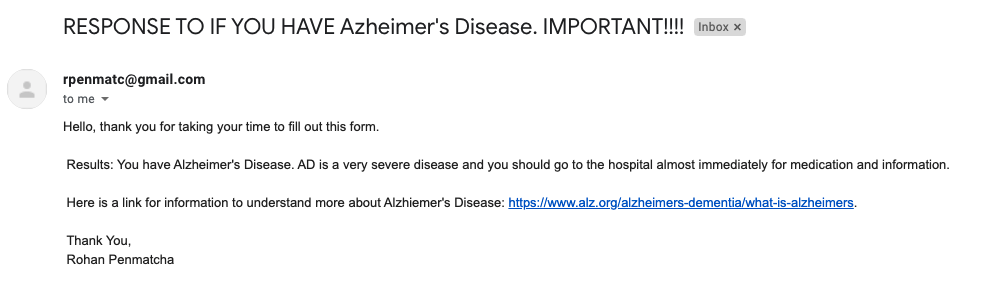

In [169]:
print ("From the User's point of view, this is how an email will look:")
from IPython.display import Image
Image(filename='EXAMPLE_AD_EMAIL.png') 